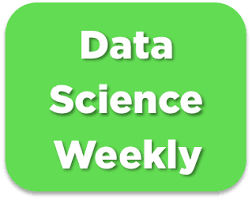

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [35]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [38]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [39]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [40]:
display(data.describe(include='all')), data.info(), data.isna().sum()

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


(None,
 None,
 country                0
 age                    0
 new_user               0
 source                 0
 total_pages_visited    0
 converted              0
 dtype: int64)

"Le dataset est propre, il ne contient pas de valeurs manquantes et les types de chaque colonne sont conformes aux données présentes. Voyons maintenant le taux de conversion de notre dataset."

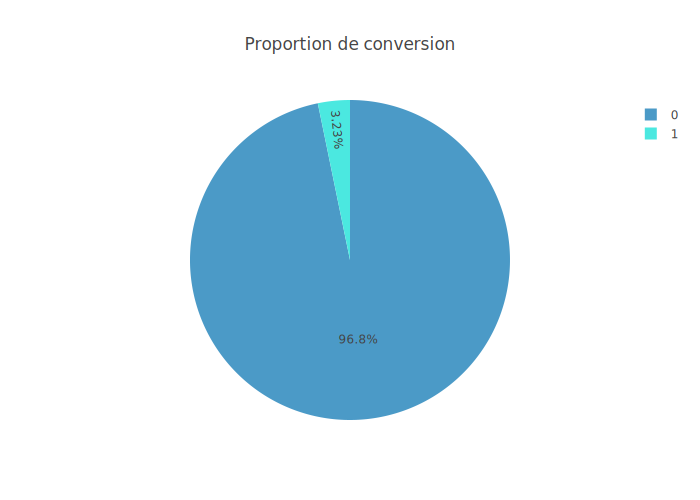

In [41]:
fig = px.pie(data, names='converted', title='Proportion de conversion')
fig.show()

Nous avons seulement 3,23 % de taux de conversion. Observons maintenant comment ce taux de conversion se répartit sur nos différentes features.


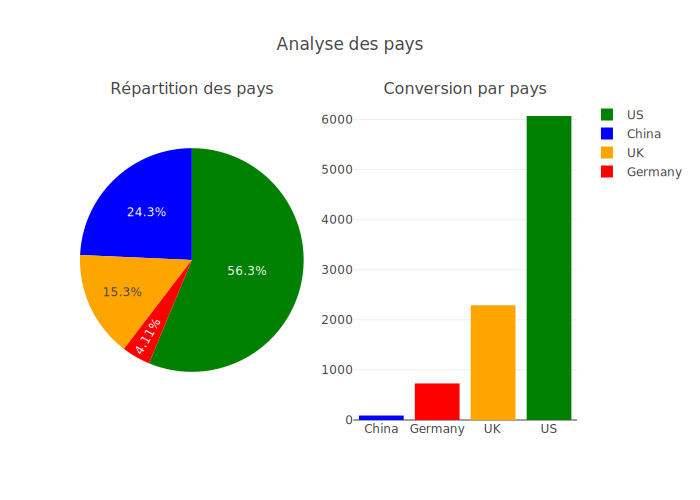

In [42]:
country = data.groupby('country')['converted'].sum()
fig = make_subplots(rows=1, cols=2,vertical_spacing=0.15, subplot_titles=('Répartition des pays', 'Conversion par pays'), specs=[[{'type':'domain'}, {'type':'xy'}]])

fig.add_trace(go.Pie(labels=data['country'].value_counts().index, values=data['country'].value_counts().values, name='country',marker=dict(colors=['green','blue','orange','red'])), row=1, col=1)
fig.add_trace(go.Bar(x=country.index, y=country.values,showlegend=False,marker=dict(color=['blue','red','orange','green'])), row=1, col=2)

fig.update_layout(title_text="Analyse des pays")
fig.show()


In [43]:
def taux_conversion(country):

    data_pays = data[data['country'] == country]
    total = data_pays.shape[0]
    convertis = data_pays[data_pays['converted'] == 1].shape[0]
    tx_conversion = convertis / total
    print(f"Le taux de conversion pour {country} est de {tx_conversion:.2%}")
    return tx_conversion

for country in data['country'].unique():
    taux_conversion(country)

Le taux de conversion pour China est de 0.13%
Le taux de conversion pour UK est de 5.25%
Le taux de conversion pour Germany est de 6.24%
Le taux de conversion pour US est de 3.79%


Les utilisateurs les plus représentés viennent des États-Unis, qui représentent plus de 50 % (56,3 %) du dataset, suivis de la Chine, du Royaume-Uni et de l'Allemagne. En termes de nombre total de conversions, ce sont naturellement les États-Unis qui arrivent en tête, suivis du Royaume-Uni, de l’Allemagne, et enfin de la Chine.
Cependant, en termes de taux de conversion, l’Allemagne est en première position (6,24 %), suivie du Royaume-Uni (5,25 %). Les États-Unis n’ont qu’un taux de conversion de 3,79 %, malgré leur forte proportion d’utilisateurs, tandis que la Chine affiche un taux très faible de 0,13 %, bien qu’elle représente 24 % des utilisateurs.

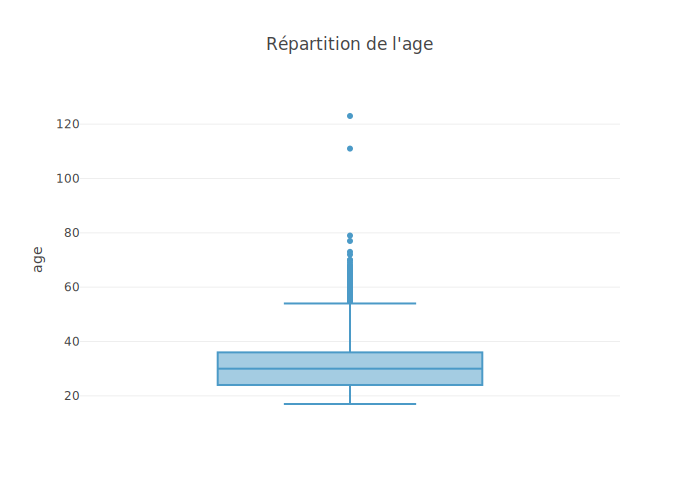

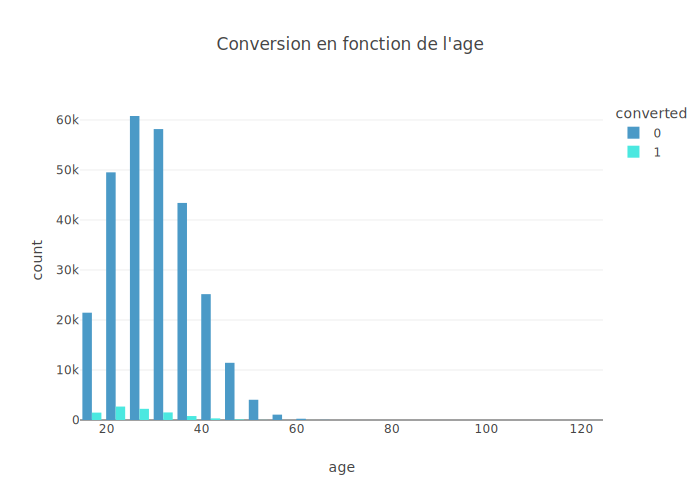

In [44]:
fig = px.box(data, y='age', title="Répartition de l'age", )
fig.show()
fig2 = px.histogram(data, x='age', color='converted', title="Conversion en fonction de l'age", barmode='group', nbins=50)
fig2.show()


L’âge montre une distribution approximativement normale, centrée autour de 30 ans. Nous observons toutefois plusieurs outliers, dont certaines valeurs aberrantes (par exemple 123 ans). Nous allons traiter ces valeurs en retirant tous les outliers.

In [45]:
valeur_palier_haut = data['age'].mean() + 3*data['age'].std()
valeur_palier_bas = data['age'].mean() - 3*data['age'].std()
outlier_condition = (data['age'] > valeur_palier_haut) | (data['age'] < valeur_palier_bas)
nombre_outliers = data[outlier_condition].shape[0]
data = data[~outlier_condition]
print(f"l'age supérieur au palier haut est {valeur_palier_haut.round(2)} ans, tout âge supérieur à cette valeur est considéré comme un outlier.")
print(f"l'age inférieur au palier bas est {valeur_palier_bas.round(2)} ans, tout âge inférieur à cette valeur est considéré comme un outlier.")
print(f"Cela représente un nombre de {nombre_outliers} outliers.")

l'age supérieur au palier haut est 55.36 ans, tout âge supérieur à cette valeur est considéré comme un outlier.
l'age inférieur au palier bas est 5.76 ans, tout âge inférieur à cette valeur est considéré comme un outlier.
Cela représente un nombre de 1017 outliers.


Nous avons supprimé un peu plus de 1 000 lignes sur 284 000, soit 0,35 % du dataset, ce qui est négligeable et n’aura pas d’impact sur notre modèle. Au contraire, cela permet de se concentrer sur les données les plus pertinentes. Observons maintenant la colonne new_user.

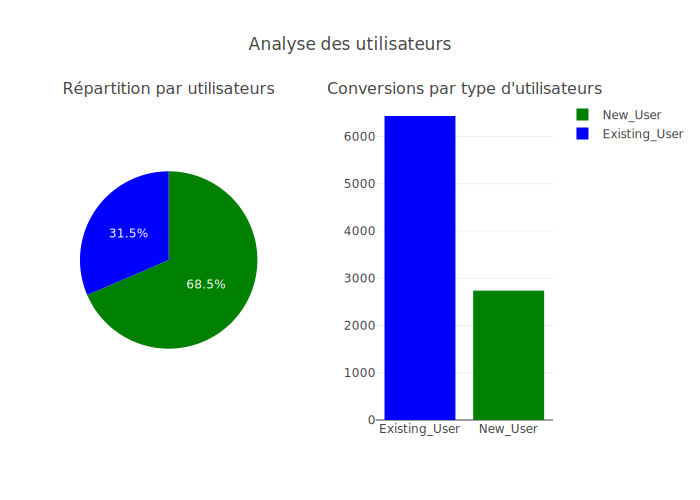

In [46]:
conversions = data.groupby('new_user')['converted'].sum().rename({1:'New_User', 0:'Existing_User'})
fig = make_subplots(rows=1, cols=2,horizontal_spacing=0.25, subplot_titles=('Répartition par utilisateurs', "Conversions par type d'utilisateurs"), specs=[[{'type':'domain'}, {'type':'xy'}]])

fig.add_trace(go.Pie(labels=data['new_user'].value_counts().index.map({1:'New_User', 0:'Existing_User'}), values=data['new_user'].value_counts().values, name='new_user',marker=dict(colors=['green','blue'])), row=1, col=1)
fig.add_trace(go.Bar( x=conversions.index, y=conversions.values,showlegend=False,marker=dict(color=['blue','green'])), row=1, col=2)

fig.update_layout(title_text="Analyse des utilisateurs")
fig.show()

In [47]:
print('Taux de conversions pour un utilisateurs déjà enregistrés :', conversions.iloc[0]*100/(data['new_user']==0).sum().round(2))
print('Taux de conversions pour un nouvel utilisateur :', conversions.iloc[1]*100/(data['new_user']==1).sum().round(2))

Taux de conversions pour un utilisateurs déjà enregistrés : 7.214368196239784
Taux de conversions pour un nouvel utilisateur : 1.408682588518568


Il est cohérent de constater qu’un utilisateur déjà enregistré a plus de chances de s’inscrire à la newsletter du site.
En effet, le taux de conversion pour un utilisateur existant est de 7,21 %, contre seulement 1,41 % pour un nouvel utilisateur. Observons maintenant la répartition selon la source des données recueillies.

In [48]:
source = data.groupby('source')['converted'].sum()
source

source
Ads       2783
Direct    1810
Seo       4580
Name: converted, dtype: int64

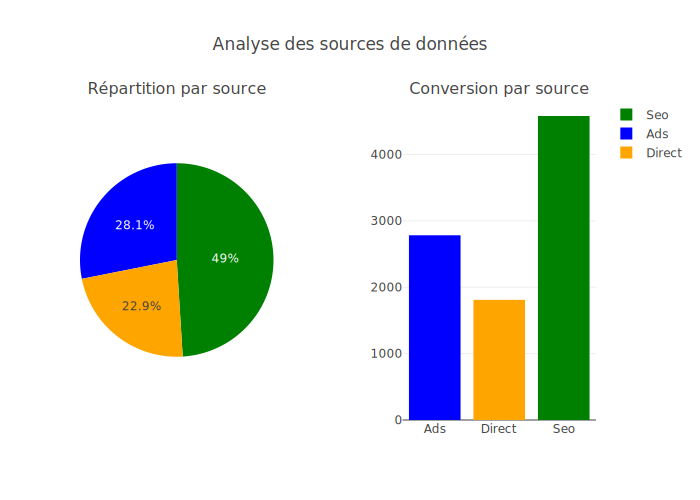

In [49]:

fig = make_subplots(rows=1, cols=2,horizontal_spacing=0.25, subplot_titles=('Répartition par source', "Conversion par source"), specs=[[{'type':'domain'}, {'type':'xy'}]])

fig.add_trace(go.Pie(labels=data['source'].value_counts().index, values=data['source'].value_counts().values, name='source',marker=dict(colors=['green','blue','orange'])), row=1, col=1)
fig.add_trace(go.Bar( x=source.index, y=source.values,showlegend=False,marker=dict(color=['blue','orange','green'])), row=1, col=2)

fig.update_layout(title_text="Analyse des sources de données")
fig.show()

In [50]:
print('Taux de conversion pour SEO :', source.iloc[2]*100/(data['source']=='Seo').sum().round(2))
print('Taux de conversion pour ADS :', source.iloc[0]*100/(data['source']=='Ads').sum().round(2))
print('Taux de conversion pour DIRECT :', source.iloc[1]*100/(data['source']=='Direct').sum().round(2))

Taux de conversion pour SEO : 3.2952010936038563
Taux de conversion pour ADS : 3.4903116573650217
Taux de conversion pour DIRECT : 2.7915728430858446


La source SEO représente près de 50 % des données collectées. Les deux autres sources se partagent le reste de manière assez équilibrée, avec Ads légèrement supérieur à Direct.

Les taux de conversion restent relativement homogènes entre les différentes sources, oscillant entre 2,79 % et 3,49 %. On remarque toutefois que Ads, qui représente un peu plus d’un quart des données, affiche le meilleur taux de conversion (3,49 %).

Pour finir, nous allons analyser le nombre total de pages visitées par type d’utilisateur et observer leur taux de conversion.

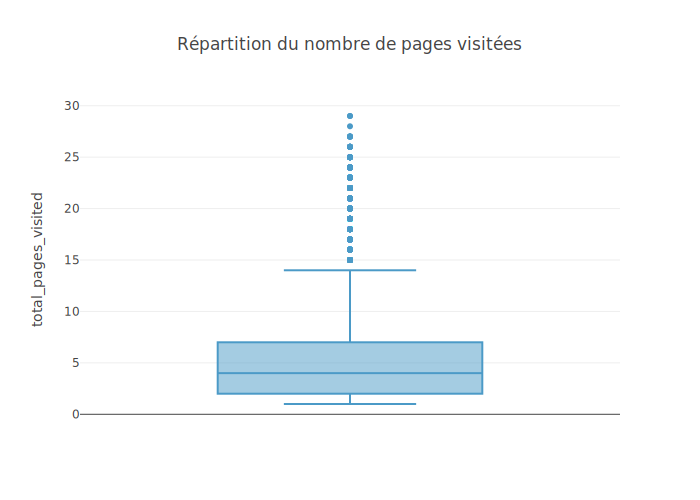

le nombre de page moyen visitée est de 4.87


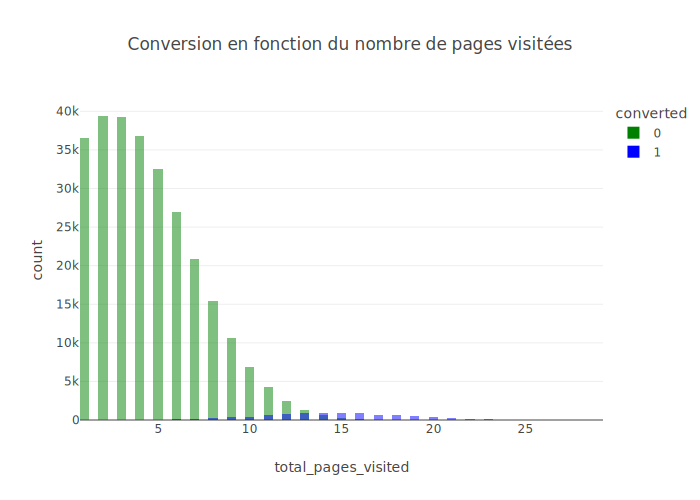

In [51]:
fig = px.box(data, y='total_pages_visited', title="Répartition du nombre de pages visitées", )
fig.show()
print("le nombre de page moyen visitée est de", data.total_pages_visited.mean().round(2))
fig2 = px.histogram(data, x='total_pages_visited', color='converted', title="Conversion en fonction du nombre de pages visitées", barmode='overlay', nbins=100, color_discrete_sequence=['green', 'blue'])
fig2.show()


Le nombre moyen de pages visitées est d’un peu moins de 5 (4,87). On constate que plus un utilisateur visite de pages, plus la probabilité de conversion augmente, avec un pic autour de la 14ᵉ page visitée.

## Pour conclure
Notre analyse exploratoire a montré que la conversion dépend de plusieurs facteurs : le pays d’origine (avec de fortes disparités entre la Chine, l’Allemagne et le Royaume-Uni), le type d’utilisateur (les anciens utilisateurs convertissant beaucoup plus que les nouveaux), ainsi que le niveau d’engagement mesuré par le nombre de pages visitées.

Ces éléments suggèrent que la conversion n’est pas due au hasard mais résulte de caractéristiques observables. Il est donc pertinent de développer un modèle prédictif de la conversion, afin d’anticiper la probabilité qu’un utilisateur s’inscrive à la newsletter en fonction de son profil et de son comportement.

# Modele de Base

In [52]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [53]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [54]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]
# Création du dataset d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)


## Training pipeline

In [55]:
# Pas de valeur manquante donc pas d'imputation juste une standardisation de la variable
featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)

classifier = LogisticRegression() 
classifier.fit(X_train, Y_train)

# Predictions sur le train
Y_train_pred = classifier.predict(X_train)

## Test pipeline

In [56]:
# on utilise le même préprocesseur que pour le train
X_test = featureencoder.transform(X_test)

# Predictions sur le test 
Y_test_pred = classifier.predict(X_test)

## F1 Score
Le F1-score est un compromis entre précision et recall. Plus le score F1 est proche de 1, plus le modèle est performant, car il combine à la fois une bonne précision et un bon recall.

In [57]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6968660570949955
f1-score on test set :  0.6815571155073389


In [58]:
# Résultat de la matrice de confusion
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[245871   1075]
 [  3268   4992]]

Confusion matrix on test set : 
[[27324   120]
 [  379   534]]



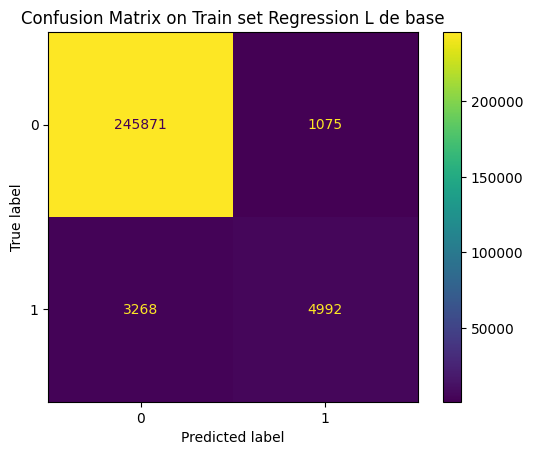

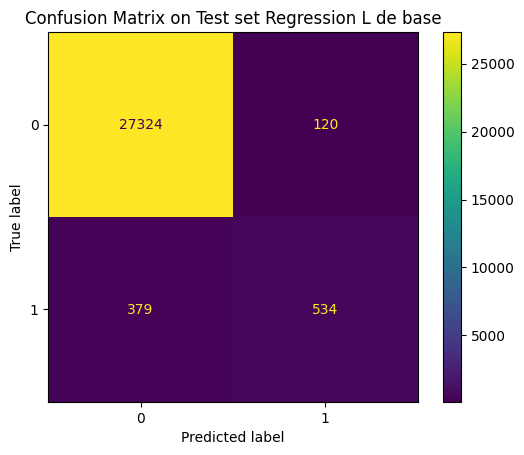

In [59]:
# Visualisation de la matrice de confusion
_, ax = plt.subplots()  
ax.set(
    title="Confusion Matrix on Train set Regression L de base"
)  
ConfusionMatrixDisplay.from_estimator(
    classifier, X_train, Y_train, ax=ax
)  
plt.show()

_, ax = plt.subplots()  
ax.set(
    title="Confusion Matrix on Test set Regression L de base"
)  
ConfusionMatrixDisplay.from_estimator(
    classifier, X_test, Y_test, ax=ax
)  
plt.show()

#### Analyse de la matrice de confusion
Beaucoup de vrais négatifs (TN) → le modèle est très bon pour reconnaître les mails non-spam.

Faux positifs (FP) très faibles → le modèle classe rarement un mail normal comme spam, c’est important car on évite de “perdre” de vrais mails.

Faux négatifs (FN) non négligeables → une partie des spams passent entre les mailles du filet (env. 379 sur le test). Cela peut être problématique si cela génère un coût de les laisser passer => perte de temps.

Vrais positifs (TP) corrects → le modèle détecte une proportion intéressante de spams, mais encore améliorable.

#### Resultat sur le TEST
Précision (Positive Predictive Value) = TP / (TP + FP) = 534 / (534 + 120) ≈ 81,6%
→ Quand le modèle dit "spam", il a raison 4 fois sur 5.

Rappel (Sensitivity/Recall) = TP / (TP + FN) = 534 / (534 + 379) ≈ 58,5%
→ Le modèle capture un peu plus de la moitié des spams → trop de spams sont encore “ratés”.

F1-score ≈ 0,68
→ Score moyen, car compromis entre précision et recall. Comme notre objectif est d’améliorer la détection des spams, il faudra chercher à augmenter le recall, même au prix d’une légère baisse de la précision.

#### Amélioration du modèle

Feature engineering

- Créer de nouvelles variables pertinentes pour aider le modèle dans sa prédiction.

Ajustement des hyperparamètres du modèle

- Utiliser class_weight='balanced' pour mieux gérer le déséquilibre éventuel entre spam et non-spam.

Ajustement du seuil de décision

Enrichissement du modèle

- Tester des algorithmes plus puissants sur ce type de tâche (Random Forest, XGBoost,...)




# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [60]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [61]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to arrays before using scikit-learn
print("Convert pandas DataFrames to arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to arrays...
...Done
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [62]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.32289692]
 [ 0.03670424]
 [-1.15827491]
 [ 0.33544903]
 [-0.56078534]]


/home/m_bar/miniconda3/envs/challenge/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [63]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
# data = {
#     'converted': classifier.predict(X_without_labels)
# }

# Y_predictions = pd.DataFrame(columns=['converted'],data=data)
# Y_predictions.to_csv('conversion_data_test_predictions_baseline.csv', index=False)


### Pour conclure
Nous disposons donc d’un modèle de base solide, notamment pour limiter les faux positifs. Cependant, il reste perfectible sur la détection des spams manqués. Passons maintenant à l’amélioration et à l’exploration d’autres modèles.
Nous commencerons par optimiser le modele de régression logistique.